# Attribution of Responsibility and Blame Regarding a Man-made Disaster: #FlintWaterCrisis

by [Talha Oz](http://talhaoz.com) and [Halil Bisgin](http://halilbisgin.com)

In [ ]:
# read the JSON data and save it to Flint.pkl once,
# whenever want to read the data, read the pickle,
# instead of the raw JSON files. 
# This code block is here just to show how we created the pickle (.pkl) file.
import pandas as pd
import json
from glob import glob
from datetime import datetime
tw = []
for f in glob("data/TweetCollection/*.json"):
    with open(f, 'r',encoding='utf-8') as fin:
        for line in fin:
            a = json.loads(line)
            tw.append({'id':a['id_str'],
                       'created_at':datetime.strptime(a['created_at'],'%a %b %d %H:%M:%S +0000 %Y'),
                       'hashtagged':any(['flintwatercrisis' in h['text'].lower() for h in a['entities']['hashtags']]),
                       'screen_name':a['user']['screen_name'],
                       'location':a['user']['location'],
                       'followers':a['user']['followers_count'],
                       'verified':bool(a['user']['verified']),
                       'text':a['text']})
df = pd.DataFrame(tw).set_index('id').drop_duplicates()
#df.to_pickle('data/Flint.pkl')

In [1]:
import pandas as pd
import numpy as np
pd.set_option('max_colwidth',200)
df = pd.read_pickle('../data/Flint.pkl')

from utilities.geocoder import Geocoder
gc = Geocoder('utilities/geodata/state_abbr_file', 'utilities/geodata/city_file')
df['latlon'] = df.location.str.strip().apply(gc.geocode)

from IPython.display import HTML
HTML(df.head().to_html(index=False)) #how the data looks like

created_at,followers,hashtagged,location,screen_name,text,verified,latlon
2016-01-15 21:00:24,265,True,"Sugar Land, Texas",zachsciba,RT @TheDailyShow: #FlintWaterCrisis could have been prevented by an easy $100/day solution. https://t.co/4Jf7oH20EX https://t.co/7fLogvuwrx,False,"(29.599580, -95.614089)"
2016-01-15 21:00:07,968,True,None,scootey,You can thank the Republican party for this #Michigan #FlintWaterCrisis #GOP #Uniteblue https://t.co/wK7IFvkk8k,False,None
2016-01-15 21:00:30,189,True,"s. pasadena,ca",steve1204,RT @TheDailyShow: #FlintWaterCrisis could have been prevented by an easy $100/day solution. https://t.co/4Jf7oH20EX https://t.co/7fLogvuwrx,False,"(34.112958, -118.155778)"
2016-01-15 21:00:09,8053,True,"Lansing, Michigan",ProgressMich,Snyder still won’t say when he knew about #FlintWaterCrisis. Protest with us on Tuesday to demand answers: https://t.co/aRfLc99QUy #MISOTS,False,"(42.717585, -84.554916)"
2016-01-15 21:00:35,7,True,None,marcgilbert77,RT @TheDailyShow: #FlintWaterCrisis could have been prevented by an easy $100/day solution. https://t.co/4Jf7oH20EX https://t.co/7fLogvuwrx,False,None


In [2]:

g = df.groupby('text').size().reset_index()
g.columns = ['text','cnt']
g = g.sort_values('cnt',ascending=False)
print('total tw:',len(df),'\nunique tw:',len(g))
g.head() #most popular tweets

total tw: 664775 
unique tw: 344384


,text,cnt
274256,RT @xoShakarra: Friendly reminder that it STILL takes one hour and 23 gallons of water to take a bath in Flint. #FlintWaterCrisis https://t…,7093
202990,RT @BernieSanders: How do we have so much money to go to war in Iraq but somehow not enough money to provide clean drinking water to Flint?…,5825
261826,"RT @markmobility: #FlintWaterCrisis \n- 99,000 residents\n- 57% Black\n- 40% Poor\n- 9,000 kids with lead poisoning\nFlint HOSPITAL Water: https…",4710
265544,RT @opinionatedcxnt: Saw this on Tumblr &amp; it made me cringe. The Flint crisis is a horrific nightmare\nhttps://t.co/j6sT5c5p3O,2354
204672,RT @BuzzFeedVideo: People See What Flint Water Looks Like\nhttps://t.co/3fV2EZFz21,1950


In [15]:
# the original dates are in UTC/GMT, convert them to EST.
# also, as given in footnote #4, report the missing dates

import pytz
eastern = pytz.timezone('US/Eastern')
# group tweets by day
df.created_at = df.created_at.dt.tz_localize(pytz.utc).dt.tz_convert(eastern)

# print missing date intervals in our dataset
day = df.groupby(df.created_at.dt.strftime('%m-%d'))['created_at'].count()
days = day.index.tolist()
for i in range(len(days)-1):
    m1,d1 = days[i].split('-')
    m2,d2 = days[i+1].split('-')
    if m1 == m2:
        if int(d1) == int(d2) - 1:
            continue
    else:
        if d2 == '01':
            continue
    print('('+days[i]+','+days[i+1]+')',end=' ')

(01-22,01-25) (02-13,02-15) (02-16,02-20) (02-20,02-29) (02-29,03-03) (04-27,05-04) (05-06,05-08) (05-12,05-26) 

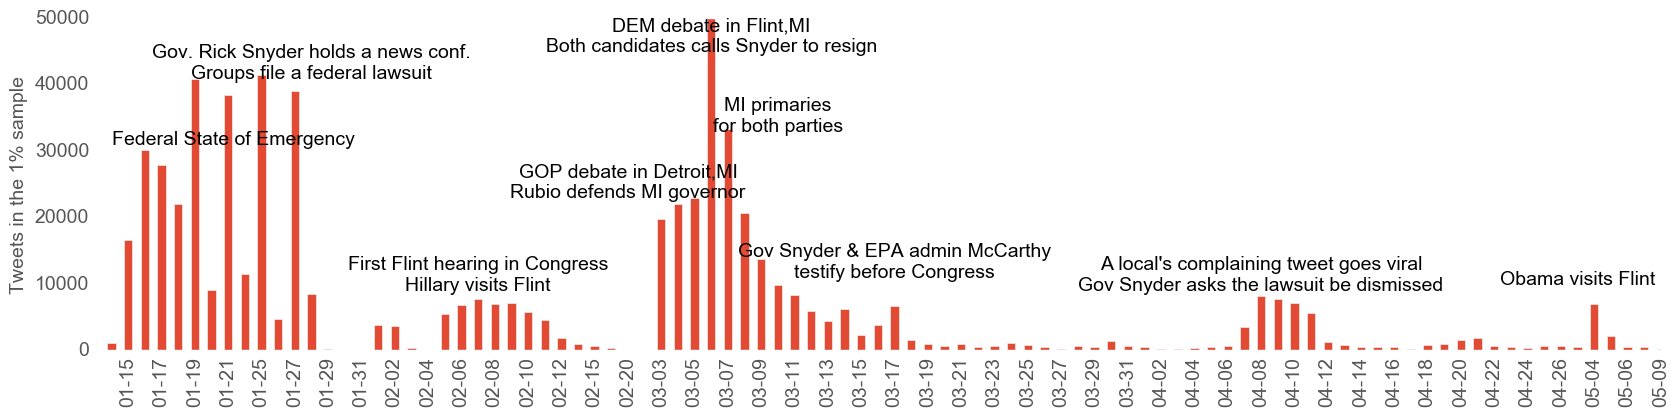

In [210]:
#Figure 1
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
matplotlib.rcParams['font.size'] = 14
#plot daily activity
ax = day.plot(kind="bar",figsize=(18, 4)) #,title='#FlintWaterCrisis Activity on Twitter'
#ax.set_xlabel('Days After Flint Became a Federal State of Emergency on 2016-01-16', fontsize=14)
ax.set_ylabel('Tweets in the 1% sample', fontsize=14)

for label in ax.xaxis.get_ticklabels()[::2]:
    label.set_visible(False)
ax.annotate('Federal State of Emergency', xy=(0, 31000))
ax.annotate('Gov. Rick Snyder holds a news conf.\n'\
            'Groups file a federal lawsuit', xy=(12, 41000),ha='center')
ax.annotate('First Flint hearing in Congress\n'\
            'Hillary visits Flint', xy=(22, 9000),ha='center')
ax.annotate('GOP debate in Detroit,MI\nRubio defends MI governor', xy=(31, 23000),ha='center')
ax.annotate('DEM debate in Flint,MI\nBoth candidates calls Snyder to resign', xy=(36, 45000),ha='center')
ax.annotate('MI primaries\nfor both parties', xy=(40, 33000),ha='center')
ax.annotate('Gov Snyder & EPA admin McCarthy\ntestify before Congress', xy=(47, 11000),ha='center')
ax.annotate('A local\'s complaining tweet goes viral\nGov Snyder asks the lawsuit be dismissed', xy=(69, 9000),ha='center')
ax.annotate('Obama visits Flint', xy=(88, 10000),ha='center')
ax.set_xlim([-1, 93])
ax.set_xlabel('');
ax.get_figure().savefig('../figs/daily.pdf',dpi=150,bbox_inches='tight')

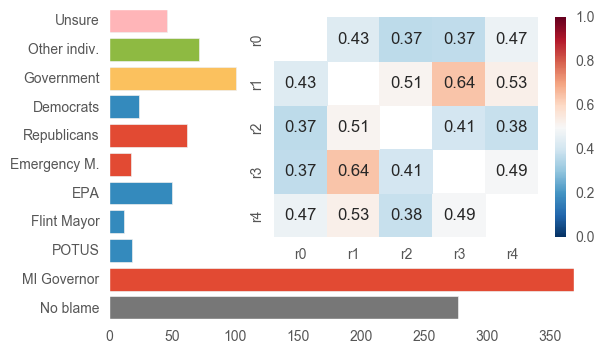

In [3]:
#Figure 2
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns

#matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('ggplot')

plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
matplotlib.rcParams['font.size'] = 14


l = pd.DataFrame()
for i in range(5):
    r = pd.read_csv('../data/training/Flint'+str(i+1)+'_train.csv')
    r['rater'] = i
    l = l.append(r)
l = l.fillna('missing')

l['label'] = l.c.replace({',.*':'','missing':10},regex=True).astype(int) #removes multiple labels

#get pairwise kappas
from itertools import combinations
from statsmodels.stats.inter_rater import fleiss_kappa
from statsmodels.stats.inter_rater import aggregate_raters

kappa = []
for r1,r2 in combinations(range(5), 2):
    rr = l[l.rater==r1].merge(l[l.rater==r2],on='text')[['label_x','label_y']]
    k = fleiss_kappa(aggregate_raters(rr,n_cat=11)[0])
    kappa.append(('r'+str(r1),'r'+str(r2),k))
    kappa.append(('r'+str(r2),'r'+str(r1),k)) #(r2,r1,k)

a = pd.DataFrame(kappa).pivot(0,1,2) #pairwise inter-rater fleiss-kappa 
a.index.name = None
a.columns.name = None


plt.figure(num=None, figsize=(6, 4), facecolor='w', edgecolor='w')

labels = ['No blame','MI Governor','POTUS','Flint Mayor',
          'EPA','Emergency M.','Republicans','Democrats','Government','Other indiv.', 'Unsure']
cnt = [len(l[l.c.str.contains(str(i))]) for i in range(10)] #count of each label
cnt.append(len(l[l.c.str.contains('missing')]))
ax = plt.subplot()
ax.margins(0, 0)
colors = '#777777 #E24A33 #348ABD #348ABD #348ABD #E24A33 #E24A33 #348ABD #FBC15E #8EBA42 #FFB5B8'.split()
#[color['color'] for color in list(plt.rcParams['axes.prop_cycle'])]
ax.barh(range(len(cnt)),cnt,tick_label=labels,align='center',color=colors)
#ax.set(xlabel='Manually coded tweets'); #title='Attribution of Blame/Responsibility',
#ax.grid(color='grey', linestyle='dotted', linewidth=0.5)


plt.axes([.4, .33, .55, .55])
sns.heatmap(a,annot=True,vmin=0,vmax=1,cmap='RdBu_r',annot_kws={'size':12})
#ax.get_figure().savefig('../figs/coders.pdf',dpi=150,bbox_inches='tight')

In [34]:
#Table 1
df1 = pd.read_csv('../data/us-city-populations.csv',usecols=['CityST','2000','2010','LAT','LON','County_Name'])
df2 = pd.read_csv('../data/city_file.csv',dtype={'lat':str,'lon':str})
df2['CityST'] = df2.city + ', ' + df2.state
cities = df1.merge(df2, on = 'CityST', how = 'inner')
cities['latlon'] = cities[['lat','lon']].apply(tuple, axis=1)
cnt = pd.DataFrame(df.groupby(by='latlon').size().reset_index().rename(columns={0:'cnt'}))
cities = cities.merge(cnt,on='latlon',how='inner').rename(columns={'2010':'cpop','County_Name':'county'})
cities = cities[cities.cnt>=3]
cities.loc[cities.cpop.isnull(),'cpop'] = cities[cities.cpop.isnull()]['2000']
cities = cities.sort_values('cnt',ascending=False).reset_index().drop(['index','LAT','LON','2000'],1)
cities.cpop = cities.cpop.astype(int)
#cities.to_csv('data/cities.csv',index=False)
cities.head(10) #tweet counts without normalization

fil = cities[cities.cpop>88].copy()
fil['normalized'] = fil.cnt * 1000 / fil.cpop
fil = fil[fil.normalized>=1]
fil.sort_values('normalized',ascending=False).head(10) #normalized

city10 = fil.sort_values('normalized',ascending=False).head(10).reset_index()
city10 = city10.rename(columns={'CityST':'Cities'})

cofil = fil.groupby(['county','state']).sum()
cofil.normalized = cofil.cnt / np.sqrt(cofil.cpop)
county10 = cofil.sort_values(by='normalized',ascending=False).head(10).reset_index()
county10['Counties'] = county10.county +', '+county10.state

cc = pd.concat([city10.Cities,county10.Counties],axis=1)
cc.index += 1
print(cc.to_latex())

\begin{tabular}{lll}
\toprule
{} &                Cities &           Counties \\
\midrule
1  &             Flint, MI &        Genesee, MI \\
2  &           Gaylord, MI &  Dist Columbia, DC \\
3  &       Grand Blanc, MI &         Otsego, MI \\
4  &      Mount Morris, MI &          Wayne, MI \\
5  &  Bloomfield Hills, MI &         Ingham, MI \\
6  &           Lansing, MI &      Washtenaw, MI \\
7  &            Sedona, AZ &       Multiple, GA \\
8  &           Davison, MI &           Kent, MI \\
9  &     Traverse City, MI &       Coconino, AZ \\
10 &         Ann Arbor, MI &           Cook, IL \\
\bottomrule
\end{tabular}



In [4]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

snyder = df.text.str.contains('governor|nyder|onetoughnerd',case=False)
EM = df.text.str.contains('mgr|manager|Darnell|Earley|Kurtz',case=False)
mayor = df.text.str.contains('Dayne|Walling|ayor',case=False)

print([len(df[x]) for x in [snyder,EM,mayor]]) #Footnote 10.

[97577, 6028, 11609]


In [3]:
from matplotlib import animation,font_manager
import matplotlib.pyplot as plt
from html import unescape
import os

plt.rcParams['savefig.dpi']=150
plt.rcParams['animation.html'] = 'html5'

fig, ax = plt.subplots(figsize=(6, 1))
ax.set_axis_off()

plt.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.1)
prop = font_manager.FontProperties(fname='Quivira.otf') # 'Symbola.ttf'
text = ax.text(.5, .5, '', fontsize=11, va='center', ha='center', wrap=True, fontproperties = prop)

txt = list(g.head(30).text) #g is a pandas dataframe

def animate(i):
    text.set_text('('+str(i+1)+') '+unescape(txt[i]))
    return (text,)

anim = animation.FuncAnimation(fig, animate, frames=len(txt), interval=2000, blit=True)
anim.save('top30.mp4') #matplotlib can save as mp4, but not as gif yet.
os.system("convert -delay 200 top30.mp4 top30.gif") #imagemagick's convert
anim #eye candy for the presentation :-)

62 24


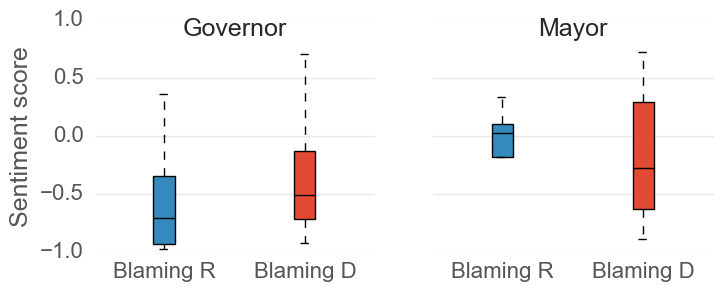

In [180]:
# Figure 3 (new)
c = pd.DataFrame()
for i in range(5):
    r = pd.read_csv('../data/training/Flint'+str(i+1)+'_train.csv')
    r['rater'] = i
    c = c.append(r)
c = c.dropna()
print(len(c[c.c.str.contains('6')]),len(c[c.c.str.contains('7')]))

r = df.screen_name[df.text.isin(c[c.c.str.contains('6')].text)]
d = df.screen_name[df.text.isin(c[c.c.str.contains('7')].text)]

m  = mayoronly[mayoronly.cmpnd!=0]
s  = snyderonly[snyderonly.cmpnd!=0]


#matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
matplotlib.rcParams['xtick.labelsize'] = 16
matplotlib.rcParams['ytick.labelsize'] = 16
matplotlib.rcParams['axes.titlesize'] = 18

co = {'color':'black'}
ma = {'color':'black','linestyle':'-'}
boxprops = dict(linestyle='-', color='black')

f, ax = plt.subplots(1, 2, sharey=True,figsize=(8,3))
titles = ['Governor','Mayor']
for i,a in enumerate([s,m]):
    bp = ax[i].boxplot([a[a.screen_name.isin(d)].cmpnd,a[a.screen_name.isin(r)].cmpnd], patch_artist=True,
             whiskerprops=co,capprops=co,medianprops=ma,boxprops=boxprops,labels=['Blaming R','Blaming D'])
    for box, color in zip(bp['boxes'], ['#348ABD','#E24A33']):
        box.set_color('black')
        box.set_facecolor(color)

    ax[i].set_title(titles[i],y=.9)
    ax[i].yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax[0].set_ylabel('Sentiment score',fontsize=18);
f.savefig('../figs/box-partisanship.pdf',dpi=150,bbox_inches='tight')

In [5]:
snyderonly = df[snyder&~mayor&~EM].copy()
mayoronly=df[mayor&~snyder&~EM].copy()
a = pd.DataFrame(list(snyderonly.text.apply(sid.polarity_scores)))
snyderonly = pd.concat([snyderonly.reset_index(),a.rename(columns={'compound':'cmpnd'})],axis=1)
a = pd.DataFrame(list(mayoronly.text.apply(sid.polarity_scores)))
mayoronly = pd.concat([mayoronly.reset_index(),a.rename(columns={'compound':'cmpnd'})],axis=1)

In [130]:
from scipy.stats import ks_2samp
from math import sqrt
c_a = 1.95 #coefficient c_a is 1.36 for alpha 0.05 and 1.95 for alpha 0.001
for i,a in enumerate([s,m]):
    print(ks_2samp(a[a.screen_name.isin(d)].cmpnd,a[a.screen_name.isin(r)].cmpnd))
    n1 = len(a[a.screen_name.isin(d)])
    n2 = len(a[a.screen_name.isin(r)])
    print('Critical value D_a:',c_a*sqrt((n1+n2)/(n1*n2)))

Ks_2sampResult(statistic=0.36016301579215487, pvalue=3.4967160958746161e-06)
0.27806837264879597
Ks_2sampResult(statistic=0.33333333333333337, pvalue=0.71191004965601257)
1.0148121747397396


262


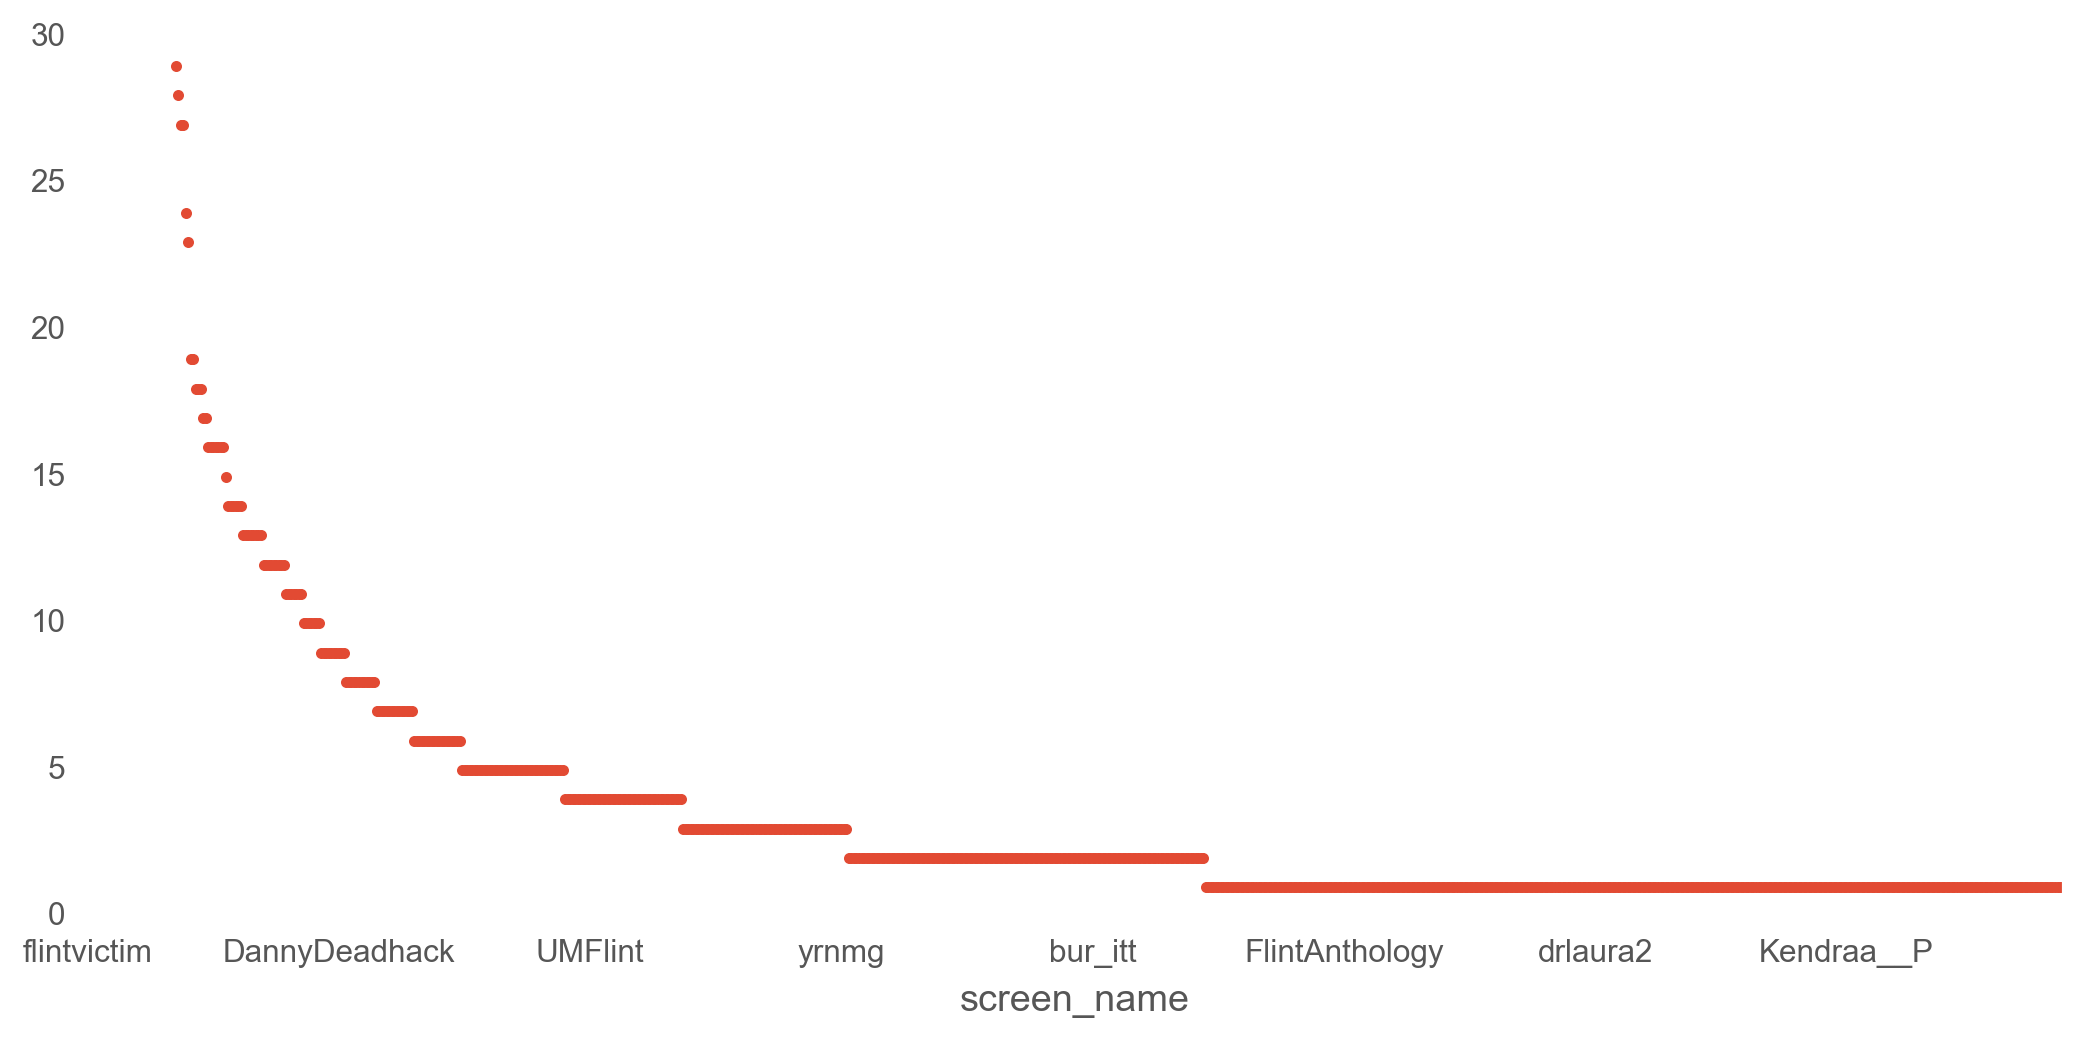

In [60]:
#now the contagion "experiment"
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import seaborn as sns
#matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
plt.rcParams['savefig.dpi']=227 #DPI of my 13.3 MacBook Pro Retina
f = df[df.latlon == gc.geocode("Flint, MI")].groupby('screen_name').size()
f.sort_values(ascending=False).plot(ylim=(0,30),linestyle="None",marker='.',figsize=(10,5))
f2 = list(f[(f>2)&(f<20)].index.values)
print(len(f2)) #Natural selection: Flinters who tweeted 2<x<20 times 

In [90]:
import twitter as t
from functools import partial
import sys, time
#friends = {}
#auth = t.oauth.OAuth("", "", "", "")
#twitter_api = t.Twitter(auth=auth)
for i,u in enumerate(f2):
    print(i+j,'trying',u)
    try:
        friends[u] = get_friends(u,twitter_api)
    except Exception as e:
        print(e)
        continue

trying EzE_2o11_
trying FGCofC
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying FYINation


Encountered 404 Error (Not Found)


trying FaithGiddings2
trying FiggaDaKID
trying FitLifeAmber
trying Flint4Bernie
trying FlintCoalition
trying FlintDDA
trying FlintFWDProject
trying FlintHandmade
trying FlintHorrorCon
trying FlintLocal432
trying FlintMI1
trying FlintPoliceOps


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying FlintRoguesRFC


...ZzZ...Awake now and trying again.


trying FlintStitch
trying FlintWaterDoc
trying FlintWaterPrjct
trying Flint_NC
trying Flintrainbowmom
trying FlintstoneQue10
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying ForgeFlint


Encountered 404 Error (Not Found)


trying FreeChoppa
trying GCHD_MI
trying GEARup2LEAD
trying GREGJOSLIN
trying Gnicole15
Twitter sent status 404 for URL: 1.1/users/lookup.json using parameters: (oauth_consumer_key=gWPAsZSr8Vff6oNEGIcZgA&oauth_nonce=1267690250305170804&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1477284134&oauth_token=2184712454-gAtpJPWGyiGMjbqXz3S0ycmKqFMDPSyBAXutBub&oauth_version=1.0&user_id=%5B50896539%2C%2051228255%5D&oauth_signature=Q551rY1rRrdYXmgvYHRafGaKxqo%3D)
details: {'errors': [{'message': 'No user matches for specified terms.', 'code': 17}]}
trying GrFlintHealthCo
trying Hashtag_Flint


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying HipHopMarauder


...ZzZ...Awake now and trying again.


trying HoodRichCain
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying HurleyMedical


Encountered 404 Error (Not Found)


trying ILikeFootball7
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying ITJBrown


Encountered 404 Error (Not Found)


trying JM3_4_INT
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying JackTriple91


Encountered 404 Error (Not Found)


trying JakeCarah
trying JamirWorld_
trying JayeMonet
trying Jaylen_22_
trying JessycaMathews
trying Jmaddy31
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying JoeBoo3


Encountered 404 Error (Not Found)


trying JonConnorMusic


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying Kasey_Posa


...ZzZ...Awake now and trying again.


trying KearsleyAD
trying KennediDiane
trying KetteringU
trying KidsPriority
trying Kiki2720
trying KodaPayne
trying LGilkey3
trying LHonestAvery
trying LWVFA
trying Leonard_Solano
trying Leonspencer1
trying Live4Gr8ness
trying Lucci2x_
trying MDOC_FOA_R6


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying MIGlutenFreeGal


...ZzZ...Awake now and trying again.


trying MMLakers
trying MVincent810
trying MakMichigan
trying MarseilleAllen
trying MattF810
trying McLovinsTwin
trying MindonGlory
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying MistaFLintastic


Encountered 404 Error (Not Found)


trying MonaHannaA
trying MoneyBall_Sam
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying MoneyMusicHeart


Encountered 404 Error (Not Found)


trying Motivated_Icon
trying MrAllinger
trying NeuvooFlint
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying NotSafeToDrink


Encountered 401 Error (Not Authorized)
Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


trying NotYourAvgSarah
trying ProjectFWC
trying QGroce
trying RandyConat
trying ReactionDJA
trying Region6PTAC
trying ReinvestFlint
trying Rev__Church_Boy
trying Rhas_Dukes
trying RickThompsonTCC
trying Rob810
trying RobinInFlint
trying RotatinMy_Tires
trying SamandFamilyy


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying SantinoGuerra


...ZzZ...Awake now and trying again.


trying Shemy
trying Simply_Jonny13
trying SkytzoBeatz
trying SloanMuseum
trying SlopeTastic
trying Spectacle_tv
trying Stoneywoney23
trying Supernova1177
trying TGreene32
trying THFtweets
trying TeacherBeard
trying TeamRevelationM
trying TeeTee45thST
trying ThaLadiesMan


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying TheMarcusJones


...ZzZ...Awake now and trying again.


trying The_X_Ray
trying ThisIsSkyy
trying ThomasJean
trying TidesOfTheSun
trying TreTaylorMusic
trying TrendingFandG
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying Trillustrator


Encountered 404 Error (Not Found)


trying Tye_Mf_Allen
trying UMFlint
trying UWGeneseeCo
trying UncleDepri
trying VideoManJamal
trying VoodooHoney
trying WCRZFM


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying WEYIKyle


...ZzZ...Awake now and trying again.
Encountered 404 Error (Not Found)


"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying WeAreFlint
trying Z927WDZZ
trying _AfterSummer
trying _HighlightReel2
trying _ImFvmousHoe
trying _JustSwangin
trying _RAMONYEA
trying _RJack1_
trying __DKA
trying __JayBenz
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying __mere02


Encountered 404 Error (Not Found)


trying _itsreallyher_
trying _jayyd0ll
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying _ruizadrianna


Encountered 404 Error (Not Found)
Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying _tiffmonique


...ZzZ...Awake now and trying again.


trying agerald68
trying ajl18_
trying alliwant_isyou
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying alynb76


Encountered 401 Error (Not Authorized)


trying andrewspeaight
trying arlrbrtsn
trying banana1015radio
trying bikermom2005
trying br14n_70
trying cacavaliers
trying callmetavis
trying car_rocky
trying cdayflint
trying cityofflintpr
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying deadlocke96


Encountered 401 Error (Not Authorized)
Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...
...ZzZ...Awake now and trying again.


trying dessi_WORLD
trying ernestoalaniz
trying fieticeira
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying firsttrinitymbc


Encountered 404 Error (Not Found)


trying fixflintfirst1
trying flintcitychurch
trying flintlibrary
trying flintsnewstalk
trying flinttownboy
trying fuck__Yu
trying get_it_cocoa
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying gggouten


Encountered 401 Error (Not Authorized)


trying goodboi021
trying gr8_bambino


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying graysam13


...ZzZ...Awake now and trying again.


trying grigg_nancy
trying grimringler
trying ididsocnu
trying itsA_Zthang
trying itstravis
trying jackfrizza
trying janathanrobinso
trying jaymarcellus
trying jem181818
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying jesssssicab


Encountered 404 Error (Not Found)


trying kevinastarnes
trying keysasmith
trying kjchristian
Twitter sent status 404 for URL: 1.1/users/lookup.json using parameters: (oauth_consumer_key=gWPAsZSr8Vff6oNEGIcZgA&oauth_nonce=13523515237202840127&oauth_signature_method=HMAC-SHA1&oauth_timestamp=1477294253&oauth_token=2184712454-gAtpJPWGyiGMjbqXz3S0ycmKqFMDPSyBAXutBub&oauth_version=1.0&user_id=%5B11245382%2C%2014096845%5D&oauth_signature=oz7O5iNVXt6fa1LOFBMIPuin2rM%3D)
details: {'errors': [{'message': 'No user matches for specified terms.', 'code': 17}]}
trying kurtneiswender


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying ladytdiva1187


...ZzZ...Awake now and trying again.


trying laylaymitchell_
trying leftinflint
trying magmagcity
trying mariano411
trying megisomeso
trying mikenstephanie
trying mona_haydar
trying mottdean
trying najladw
trying nienie_strangep
trying novaprime79
trying orochiburenso
trying overall3171
trying p85rice


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying pageiv


...ZzZ...Awake now and trying again.


trying patandaj
trying peoplevssnyder
trying planetofboom
trying rappolee
trying ronfonger
trying rubosuave
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying seonthompson


Encountered 404 Error (Not Found)


trying sexynacole
trying sharrington2016
trying simply1m3
"['id_str' 'screen_name' 'name' 'location' 'description' 'created_at'\n 'friends_count' 'followers_count' 'statuses_count' 'favourites_count'] not in index"
trying smhodges4


Encountered 401 Error (Not Authorized)


trying standupflint
trying stevemintline
trying swaydalyricist


Encountered 429 Error (Rate Limit Exceeded)
Retrying in 15 minutes...ZzZ...


trying tammy_loren


...ZzZ...Awake now and trying again.


trying tdgalbraith
trying teenagev0w
trying tenacitybrewing
trying theTOMTOMSmusic
trying whitingflint
trying xojassx
trying yrnmg
trying zachizz1476


In [111]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

ff = pd.concat(friends.values(), keys=friends.keys(),names=['flinter'])
#ff.to_csv('../data/ff.csv')
fr = ff.screen_name.unique()
sents = pd.DataFrame(list(df[df.screen_name.isin(fr)].text.apply(sid.polarity_scores)))['compound']
fs = pd.concat([df[df.screen_name.isin(fr)].screen_name.reset_index(), sents],axis=1,ignore_index=True)
fs.columns = ['twid','screen_name','cmpnd']

In [90]:
ffdf = pd.read_csv('../data/ffdf.csv')
ffdf.columns = ['screen_name'] + list(ffdf.columns[1:])
#ffdf.head() #fsent is missing
print(len(ffdf[ffdf.usent>0]),len(ffdf[ffdf.usent<0]))

101 115


In [152]:
udf = {}
for u in ffdf.index.values:
    usent = pd.DataFrame(list(df[df.screen_name == u].text.apply(sid.polarity_scores)))['compound']
    udf[u] = {'utwcnt':len(usent),'usent':usent.mean()}
usdf = pd.DataFrame.from_dict(udf,orient='index')
usdf

,utwcnt,usent
1Goal1Passion,7,0.096586
1_namillionme37,10,-0.215550
810DIRTVILLE,4,0.000000
AD16Gaming,6,0.128550
AdamBiggers81,8,0.315200
AliciaRoose,6,0.078383
AllahnaSteve,3,-0.467833
AmandaEmeryNews,19,-0.415800
Americans4Flint,5,0.265980
AmourNiyy_,4,0.411850


In [158]:
fdf = {}
for k,v in friends.items():
    fsk = fs[fs.screen_name.isin(v.screen_name)]
    fsent = fsk.cmpnd.mean()
    fdf[k] = {'ftwcnt':len(fsk),'dfcnt':len(fsk.screen_name.unique()),'tfcnt':len(v),'fsent':fsent}
ffdf = pd.DataFrame.from_dict(fdf,orient='index')
ffdf = ffdf.join(usdf)
#ffdf.to_csv('../data/ffdf.csv')
ffdf

,fsent,tfcnt,ftwcnt,dfcnt,utwcnt,usent
1Goal1Passion,-0.118901,505,2330,124,7,0.096586
1_namillionme37,-0.154041,634,458,37,10,-0.215550
810DIRTVILLE,-0.050515,987,2607,86,4,0.000000
AD16Gaming,0.000000,53,1,1,6,0.128550
AdamBiggers81,-0.082383,1327,1219,154,8,0.315200
AliciaRoose,-0.096432,918,319,44,6,0.078383
AllahnaSteve,-0.081462,70,50,19,3,-0.467833
AmandaEmeryNews,-0.103015,468,3682,197,19,-0.415800
Americans4Flint,-0.097908,354,3374,90,5,0.265980
AmourNiyy_,-0.043152,265,148,41,4,0.411850


In [207]:
len(fr),df[df.screen_name.isin(fr)].screen_name.nunique()

(122953, 8339)

In [205]:
print(len(ffdf[ffdf.usent>0]),len(ffdf[ffdf.usent<0]),len(ffdf[ffdf.fsent>0]),len(ffdf[ffdf.fsent<0]))

101 115 15 206


In [167]:
ffdf.corr(method='pearson') #.loc['fsent','usent'] = .16

,fsent,tfcnt,ftwcnt,dfcnt,utwcnt,usent
fsent,1.000000,-0.041997,-0.011399,0.044034,-0.128727,0.161092
tfcnt,-0.041997,1.000000,0.150289,0.588166,0.023542,-0.076660
ftwcnt,-0.011399,0.150289,1.000000,0.487535,0.185268,-0.001390
dfcnt,0.044034,0.588166,0.487535,1.000000,0.094961,0.030336
utwcnt,-0.128727,0.023542,0.185268,0.094961,1.000000,-0.108274
usent,0.161092,-0.076660,-0.001390,0.030336,-0.108274,1.000000


In [211]:
ffdf[ffdf.usent>0].fsent.mean(),ffdf[ffdf.usent<0].fsent.mean()

(-0.074941076829484934, -0.10539607280382769)

-0.105396072804 -0.0749410768295


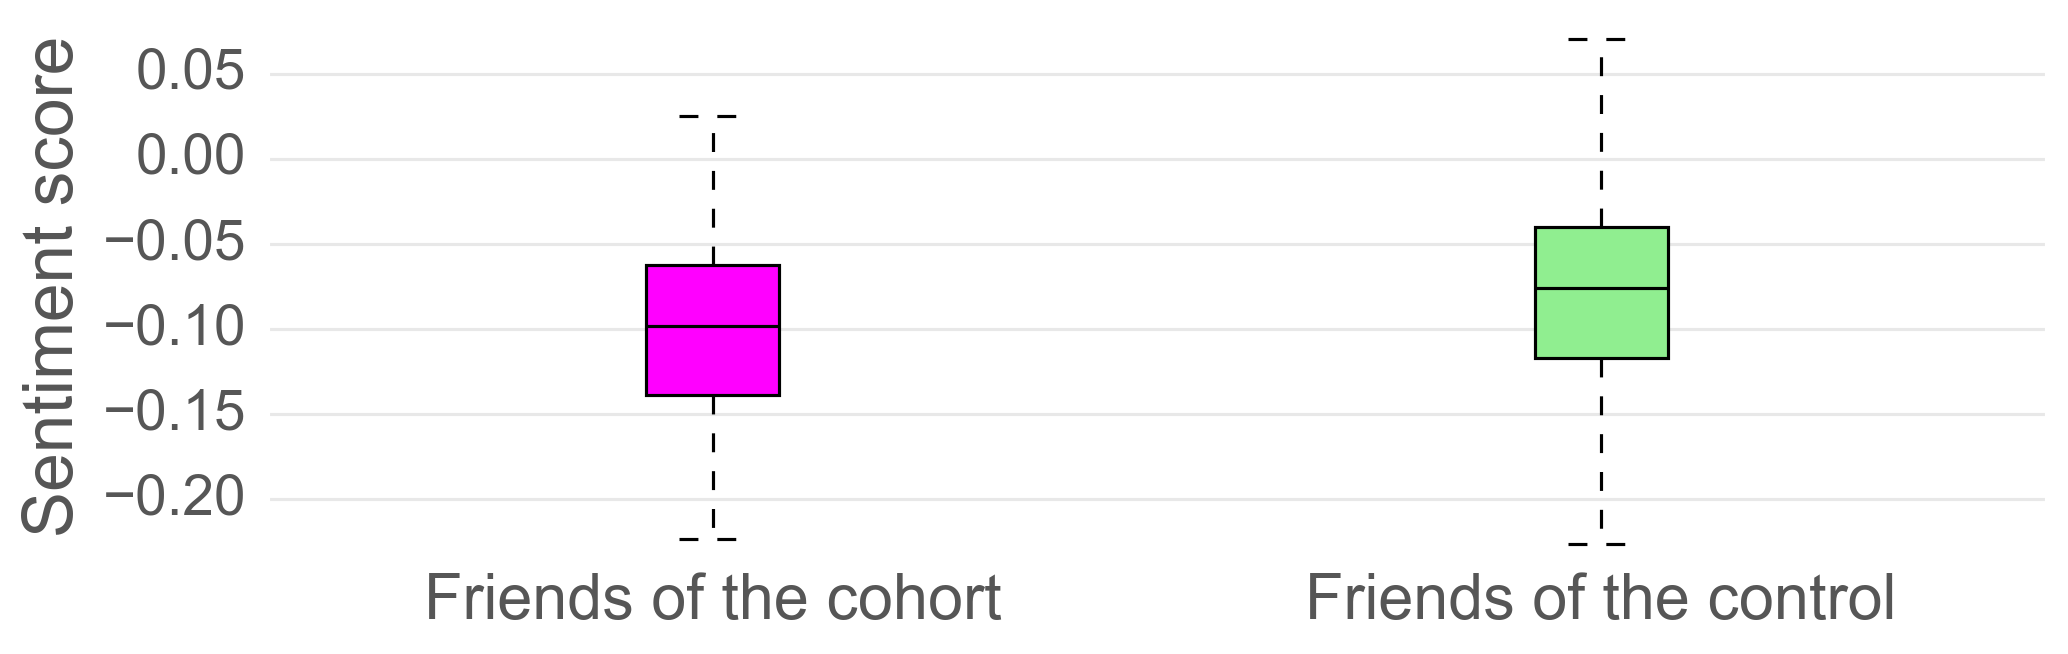

In [228]:

colorm = dict(boxes='lightgreen', whiskers='black', medians='black', caps='black')
#ax=compare[['followers','population']].plot(kind='box', patch_artist=True, showfliers=False)
boxprops = dict(linestyle='-', color='black')

matplotlib.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 14

co = {'color':'black'}
ma = {'color':'black','linestyle':'-'}

plt.figure(figsize=(9,3))
cohort = ffdf[ffdf.usent<0].fsent #ffdf[ffdf.fsent<0].usent 
control= ffdf[ffdf.usent>0].fsent.dropna() #ffdf[ffdf.fsent>0].usent
print(cohort.mean(),control.mean())
bp = plt.boxplot([cohort,control],patch_artist=True, showfliers=False,
                 whiskerprops=co,capprops=co,medianprops=ma,boxprops=boxprops,labels=['Friends of the cohort','Friends of the control'])

ax = plt.gca()
for patch, color in zip(bp['boxes'], ['magenta','lightgreen']):
    patch.set_facecolor(color)
ax.set_ylabel('Sentiment score',fontsize=22)
ax.set_ylim(-.23,.08)
#plt.yticks(np.arange(-.6, .6, .1))
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_figure().savefig('../figs/contagion-exp2.pdf', bbox_inches='tight')

In [193]:
from scipy.stats import ks_2samp
from math import sqrt
c_a = 1.36 #coefficient c_a is 1.36 for alpha 0.05 and 1.95 for alpha 0.001
print(ks_2samp(ffdf[ffdf.fsent<0].usent,ffdf[ffdf.fsent>0].usent))
n1 = len(ffdf[ffdf.fsent<0])
n2 = len(ffdf[ffdf.fsent>0])
print('Critical value D_a (ks statistic (D) should be greater than this):',c_a*sqrt((n1+n2)/(n1*n2)))
#that is the case for 95% confidence level: https://daithiocrualaoich.github.io/kolmogorov_smirnov/

Ks_2sampResult(statistic=0.37184466019417473, pvalue=0.030545168312102647)
Critical value D_a (ks statistic (D) should be greater than this): 0.3637104720012413


In [214]:
from scipy.stats import ks_2samp
from math import sqrt
c_a = 1.36 #coefficient c_a is 1.36 for alpha 0.05 and 1.95 for alpha 0.001
print(ks_2samp(ffdf[ffdf.usent<0].fsent,ffdf[ffdf.usent>0].fsent))
n1 = len(ffdf[ffdf.usent<0])
n2 = len(ffdf[ffdf.usent>0])
print('Critical value D_a (ks statistic (D) should be greater than this):',c_a*sqrt((n1+n2)/(n1*n2)))
#that is the case for 95% confidence level: https://daithiocrualaoich.github.io/kolmogorov_smirnov/

Ks_2sampResult(statistic=0.20619888075764092, pvalue=0.01743249763074449)
Critical value D_a (ks statistic (D) should be greater than this): 0.1854625286897552


In [66]:
def get_friends(screen_name,twitter_api,limit=5000):
    get_followers_ids = partial(make_twitter_request,twitter_api.friends.ids, count=5000)
    ids = []

    cursor = -1
    while cursor != 0:
        response = get_followers_ids(screen_name=screen_name, cursor=cursor)

        if response is not None:
            ids += response['ids']
            cursor = response['next_cursor']

        # print('Fetched {0} total {1} ids for {2}. next_cursor: {3}'.format(
        #    len(ids), label, screen_name, cursor))

        if len(ids) >= limit or response is None:
            break

    return ids_to_snames(twitter_api,ids[:limit],screen_name=screen_name)


def ids_to_snames(twitter_api,fids,screen_name='tozcss'):
    get_snames = partial(make_twitter_request,twitter_api.users.lookup)
    resp = []
    for i in range(1+(len(fids)-1)//100):
        resp.extend(get_snames(user_id=fids[100*i:100*(i+1)]))
    header = ['id_str','screen_name', 'name', 'location', 'description', 'created_at', \
        'friends_count','followers_count','statuses_count','favourites_count']
    df = pd.DataFrame.from_dict(resp)[header].set_index('id_str')
    return df

def make_twitter_request(twitter_api_func, max_errors=10, *args, **kw):

    # A nested helper function that handles common HTTPErrors. Return an updated
    # value for wait_period if the problem is a 500 level error. Block until the
    # rate limit is reset if it's a rate limiting issue (429 error). Returns None
    # for 401 and 404 errors, which requires special handling by the caller.
    def handle_twitter_http_error(e, wait_period=2, sleep_when_rate_limited=True):

        if wait_period > 3600: # Seconds
            print ('Too many retries. Quitting.',file=sys.stderr)
            raise e

        # See https://dev.twitter.com/docs/error-codes-responses for common codes

        if e.e.code == 401:
            print ('Encountered 401 Error (Not Authorized)',file=sys.stderr)
            return None
        elif e.e.code == 404:
            print ('Encountered 404 Error (Not Found)',file=sys.stderr)
            return None
        elif e.e.code == 429:
            print ('Encountered 429 Error (Rate Limit Exceeded)',file=sys.stderr)
            if sleep_when_rate_limited:
                print ("Retrying in 15 minutes...ZzZ...",file=sys.stderr)
                sys.stderr.flush()
                time.sleep(60*15 + 5)
                print ('...ZzZ...Awake now and trying again.',file=sys.stderr)
                return 2
            else:
                raise e # Caller must handle the rate limiting issue
        elif e.e.code in (500, 502, 503, 504):
            print ('Encountered',e.e.code,'Error. Retrying in',wait_period,'seconds',file=sys.stderr)
            time.sleep(wait_period)
            wait_period *= 1.5
            return wait_period
        else:
            raise e

    # End of nested helper function

    wait_period = 2
    error_count = 0

    while True:
        try:
            return twitter_api_func(*args, **kw)
        except t.api.TwitterHTTPError as e:
            error_count = 0
            wait_period = handle_twitter_http_error(e, wait_period)
            if wait_period is None:
                return
        except URLError as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print ("URLError encountered. Continuing.",file = sys.stderr)
            if error_count > max_errors:
                print ("Too many consecutive errors...bailing out.",file=sys.stderr)
                raise
        except BadStatusLine as e:
            error_count += 1
            time.sleep(wait_period)
            wait_period *= 1.5
            print ("BadStatusLine encountered. Continuing.",file=sys.stderr)
            if error_count > max_errors:
                print ("Too many consecutive errors...bailing out.",file=sys.stderr)
                raise

In [56]:
import subprocess #the table that went into the presentation
template = r'''\documentclass[preview]{{standalone}}
\usepackage{{booktabs}}
\usepackage[vcentering,dvips]{{geometry}}
\geometry{{total={{3.05in}}}}
\begin{{document}}
{}
\end{{document}}
'''
filename="../figs/concerned_geo.tex"
with open(filename, 'w') as f:
    f.write(template.format(cc.to_latex()))
subprocess.call(['pdflatex', filename],cwd=r'../figs');

# The rest is not used in the paper

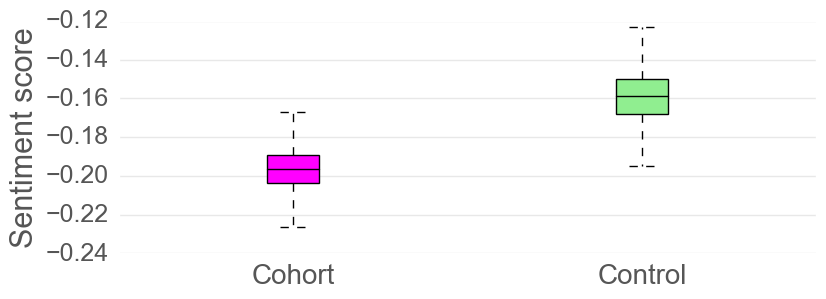

In [160]:
# Figure 4 of version1
compare = pd.read_table('../data/popVSfollower1000.txt',header=0, sep="\t")
colorm = dict(boxes='lightgreen', whiskers='black', medians='black', caps='black')
#ax=compare[['followers','population']].plot(kind='box', patch_artist=True, showfliers=False)
boxprops = dict(linestyle='-', color='black')

matplotlib.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
matplotlib.rcParams['xtick.labelsize'] = 20
matplotlib.rcParams['ytick.labelsize'] = 18
matplotlib.rcParams['axes.titlesize'] = 14

co = {'color':'black'}
ma = {'color':'black','linestyle':'-'}

plt.figure(figsize=(9,3))
bp = plt.boxplot([compare.followers,compare.population],patch_artist=True, showfliers=False,
                 whiskerprops=co,capprops=co,medianprops=ma,boxprops=boxprops,labels=['mayor','governor'])

ax = plt.gca()
for patch, color in zip(bp['boxes'], ['magenta','lightgreen']):
    patch.set_facecolor(color)
ax.xaxis.set_ticklabels(['Cohort','Control'])
ax.set_ylabel('Sentiment score',fontsize=22)
#ax.set_ylim([-.23, -.12])
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_figure().savefig('../figs/contagion-exp.pdf', bbox_inches='tight')

-0.122567031844
-0.312806395394


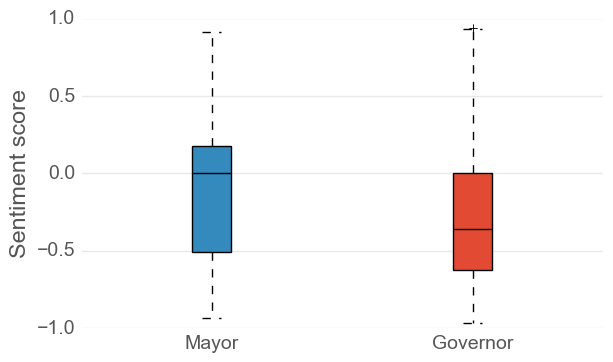

In [214]:
# Figure 3
mayonly_avgsent=pd.DataFrame(mayoronly.groupby(['screen_name'],as_index=False).mean()['sent'])
snyderonly_avgsent=pd.DataFrame(snyderonly.groupby(['screen_name'],as_index=False).mean()['sent'])


print(mayonly_avgsent.sent.mean())
print(snyderonly_avgsent.sent.mean())

# fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True)
colorm = dict(boxes='magenta', whiskers='black', medians='black', caps='black')
colorg = dict(boxes='lightgreen', whiskers='black', medians='black', caps='black')

#matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('ggplot')
plt.rcParams['axes.facecolor']='w'
plt.rcParams['savefig.facecolor']='w'
matplotlib.rcParams['font.size'] = 14
#plt.figure(num=None, figsize=(12, 8), facecolor='w', edgecolor='w')

c = {'color':'black'}
m = {'color':'black','linestyle':'-'}
boxprops = dict(linestyle='-', color='black')
bp = plt.boxplot([mayonly_avgsent,snyderonly_avgsent], patch_artist=True,
                 whiskerprops=c,capprops=c,medianprops=m,boxprops=boxprops,labels=['Mayor','Governor'])

for patch, color in zip(bp['boxes'], ['#348ABD','#E24A33']):
    patch.set_facecolor(color)

ax = plt.gca()
ax.set_ylabel('Sentiment score')
ax.yaxis.grid(True, linestyle='-', which='major', color='lightgrey', alpha=0.5)
ax.get_figure().savefig('../figs/box-mayor-gov.pdf',dpi=150,bbox_inches='tight')

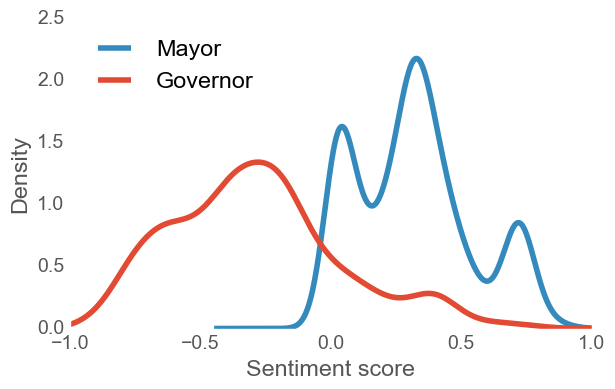

In [217]:
# Figure 4
mayonly_avgsent=pd.DataFrame(mayoronly.groupby(['screen_name'],as_index=False)['sent'].mean())
snyderonly_avgsent=pd.DataFrame(snyderonly.groupby(['screen_name'],as_index=False)['sent'].mean())

pro_may_avgent = mayonly_avgsent[mayonly_avgsent.sent>0].screen_name.unique()
comment_both = snyderonly_avgsent[snyderonly_avgsent.screen_name.isin(pro_may_avgent)].screen_name.unique()

ax=mayonly_avgsent[mayonly_avgsent.screen_name.isin(comment_both) & mayonly_avgsent.sent!=0].sent.plot(kind='density', xlim=(-1,1),color='#348ABD')
snyderonly_avgsent[snyderonly_avgsent.screen_name.isin(comment_both) & snyderonly_avgsent.sent!=0 ].sent.plot(kind='density', ax=ax, xlim=(-1,1), color = '#E24A33')
ax.legend(['Mayor','Governor'],loc=2)
ax.set_xlabel('Sentiment score')
ax.get_figure().savefig('../figs/pro_mayors_gov.pdf', bbox_inches='tight')

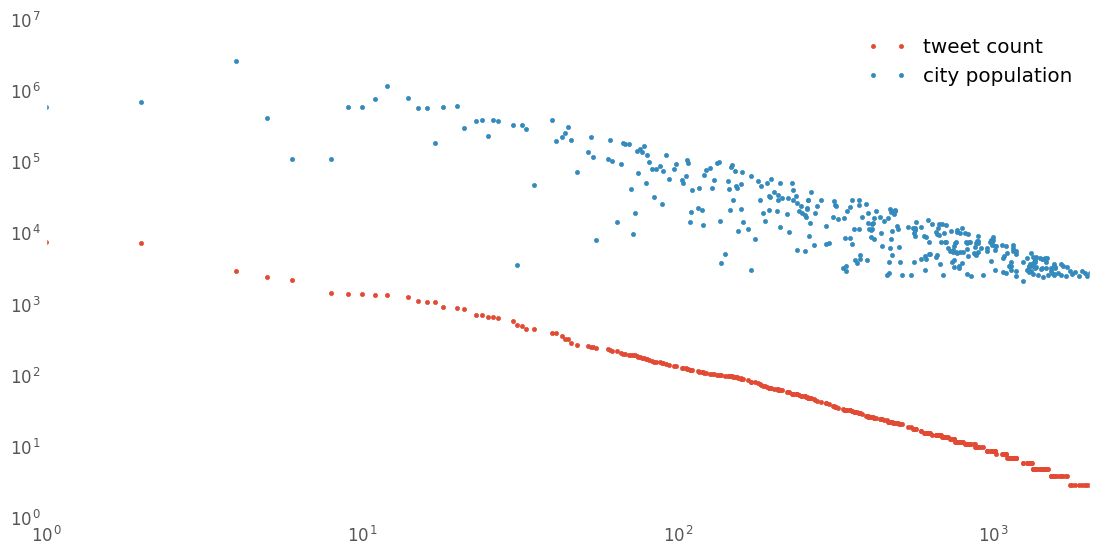

In [137]:
plt.figure(num=None, figsize=(12, 6), facecolor='w', edgecolor='w')
fil.cnt.plot(loglog=True,linestyle='',marker='.')
fil.cpop.plot(loglog=True,linestyle='',marker='.')
#fil.normalized.plot(loglog=True,linestyle='',marker='.')
plt.legend(['tweet count','city population']);

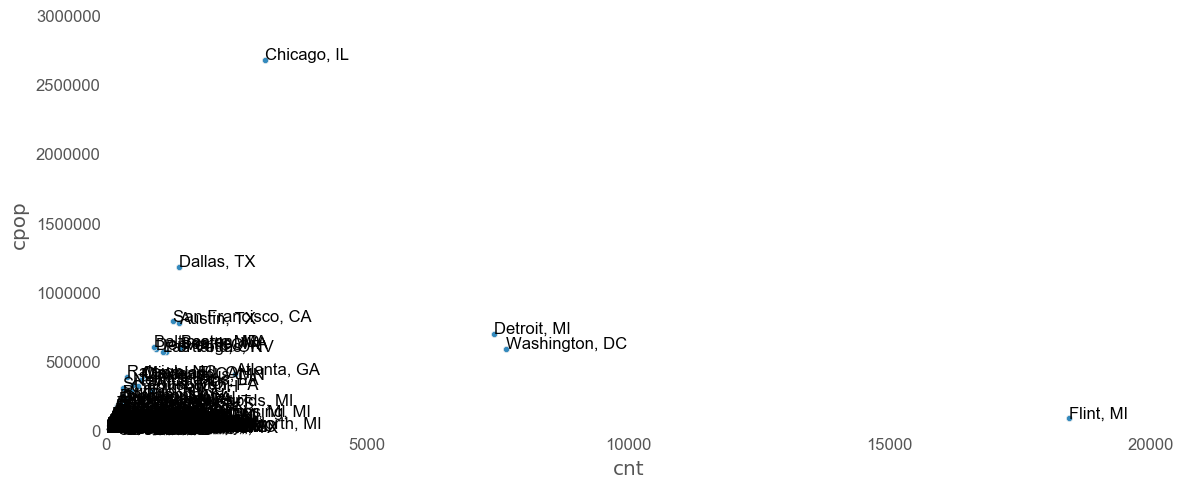

In [98]:
ax = fil.plot.scatter(x='cnt',y='cpop',figsize=(12,5))
fil[['cnt','cpop','CityST']].apply(lambda x: ax.text(*x),axis=1);
plt.xlim(0,20000);
plt.ylim(0,3000000);

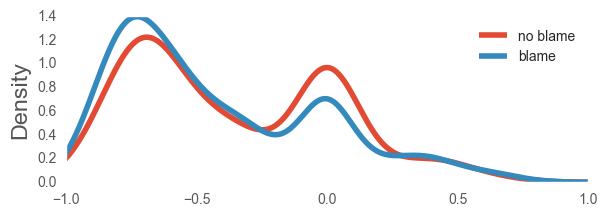

In [12]:
#compare the sentiments of blame and no-blame tweets
from nltk.sentiment.vader import SentimentIntensityAnalyzer

sid = SentimentIntensityAnalyzer()
nobl = pd.DataFrame(list(l[l.c=='1'].text.apply(sid.polarity_scores)))['compound']
blame = pd.DataFrame(list(l[l.c!='2'].text.apply(sid.polarity_scores)))['compound']

nobl.plot.density()
blame.plot.density()
plt.legend(['no blame','blame'])
plt.xlim(-1,1);
plt.gcf().set_size_inches(6,2)
#plt.gcf().savefig('../figs/blame-sentiment.pdf',dpi=150,bbox_inches='tight')

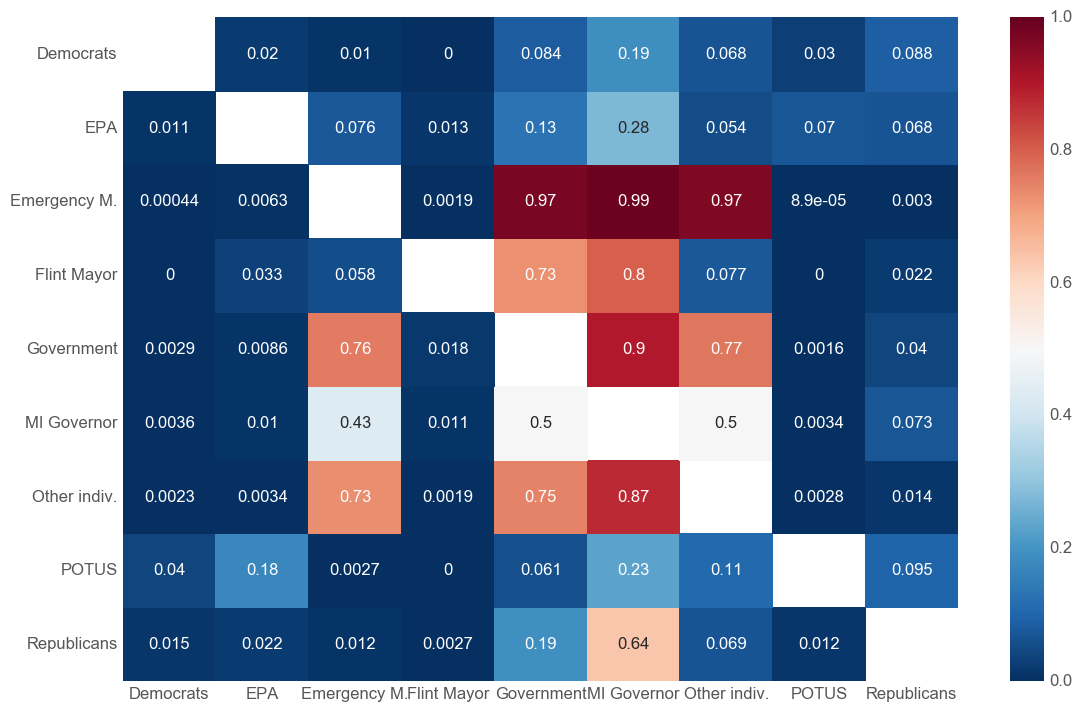

In [99]:
blamers = [df[df.text.isin(l[l.c.str.contains(str(i))].text.unique())].screen_name.unique() for i in range(10)]
blamers.append(df[df.text.isin(l[l.c == 'missing'].text.unique())].screen_name.unique())
blamers = pd.DataFrame(blamers).transpose()
blamers.columns = labels
blamers.apply(pd.Series.nunique) #number of (unique) blamers

from collections import defaultdict
from itertools import permutations
r = defaultdict(dict)
for a1,a2 in permutations(range(1,10), 2):
    s1 = set(df[df.screen_name.isin(blamers[labels[a1]])].text.unique())
    s2 = set(df[df.screen_name.isin(blamers[labels[a2]])].text.unique())
    r[labels[a1]][labels[a2]] = len(s1 & s2) / len(s2)
plt.figure(num=None, figsize=(12, 8), facecolor='w', edgecolor='w')
z = pd.DataFrame.from_dict(r) #what percentage of blamers of x also blame y
sns.heatmap(z,annot=True,vmin=0,vmax=1,cmap='RdBu_r',annot_kws={'size':12});

In [199]:
#import nltk
#nltk.download('wordnet')
from nltk.corpus import wordnet as wn
from collections import defaultdict

synonyms = defaultdict(set)
words = 'blame fault responsible fail resign jail prison sentence accountable liable cause accuse treason poison'
for w in words.split():
    for synset in wn.synsets(w):
        synonyms[w].update([lemma.name() for lemma in synset.lemmas()])
from pprint import pprint
pprint(dict(synonyms),indent=2,width=300)

{ 'accountable': {'accountable'},
  'accuse': {'accuse', 'criminate', 'charge', 'incriminate', 'impeach'},
  'blame': {'goddamn', 'darned', 'damn', 'incrimination', 'goddamned', 'inculpation', 'fault', 'damned', 'blamed', 'charge', 'goddam', 'find_fault', 'deuced', 'blame', 'blasted', 'infernal', 'rap', 'pick', 'blessed'},
  'cause': {'causa', 'effort', 'movement', 'cause', 'suit', 'causal_agent', 'do', 'make', 'stimulate', 'drive', 'crusade', 'reason', 'campaign', 'case', 'lawsuit', 'induce', 'get', 'causal_agency', 'have', 'grounds'},
  'fail': {'give_way', 'give_out', 'run_out', 'miscarry', 'go_wrong', 'die', 'fail', 'flush_it', 'bomb', 'break', 'neglect', 'conk_out', 'go_bad', 'flunk', 'betray', 'go', 'break_down'},
  'fault': {'shift', 'error', 'faulting', 'mistake', 'geological_fault', 'defect', 'break', 'fault', 'flaw', 'demerit', 'fracture', 'blame'},
  'jail': {'lag', 'poky', 'jail', 'jailhouse', 'incarcerate', 'remand', 'clink', 'slammer', 'imprison', 'immure', 'pokey', 'jug'

In [208]:
blame_words = {'responsible': 'account responsible blame accus[ie] \sliab \scause',
    'fault': 'fault error mistake flaw',
    'reason': 'ignor negl[ie] accident discriminat intention ideology decisi',
    'sentenced': 'arrest convict jail jug bars prison sentence',
    'betrayed': 'betray traitor treason',
    'resign': 'resign quit remove.+office leave.+office step\sdown',
    'poison': 'poison'}
bw = {}
for k,v in blame_words.items():
    bw[k] = v.split()
bw = pd.DataFrame.from_dict(blame_words, orient='index').rename(columns={0:'blame words per category'})

print(bw.to_latex())

\begin{tabular}{ll}
\toprule
{} &                                       blame words per category \\
\midrule
fault       &                                       fault error mistake flaw \\
poison      &                                                         poison \\
betrayed    &                                         betray traitor treason \\
responsible &             account responsible blame accus[ie] \textbackslashsliab \textbackslashscause \\
sentenced   &                   arrest convict jail jug bars prison sentence \\
resign      &           resign quit remove.+office leave.+office step\textbackslashs down \\
reason      &  ignor negl[ie] accident discriminat intention ideology decisi \\
\bottomrule
\end{tabular}



In [212]:
blame_words = {'responsible': 'account responsible blame accus[ie] \sliab \scause',
    'fault': 'fault error mistake flaw',
    'reason': 'ignor negl[ie] accident discriminat intention ideology decision',
    'sentenced': 'arrest convict jail jug bars prison sentence',
    'betrayed': 'betray traitor treason',
    'resign': 'resign quit remove.+office leave.+office step\sdown',
    'poison': 'poison'}
blame_tw = {} #unique text
blame_rt = {} #rt matters
total = set()
for k,v in blame_words.items():
    indices = set.union(*[set(df[df.text.str.contains(w,case=False)].index) for w in v.split()])
    blame_tw[k] = df.loc[indices,].text.nunique()
    blame_rt[k] = len(indices)
    total.update(indices)
blame_rt['total'] = len(total)
blame_tw['total'] = df.loc[total,].text.nunique()
pd.DataFrame([blame_rt,blame_tw],index=['tweets in the dataset (RTs count)','# of tweets w/ unique text'])

,betrayed,fault,poison,reason,resign,responsible,sentenced,total
tweets in the dataset (RTs count),400,6047,51513,9233,17224,20961,20809,113340
# of tweets w/ unique text,292,2851,19338,4288,7795,11886,9663,50700


In [213]:
l = [v.split() for v in blame_words.values()]
blame_filter = '|'.join([item for sublist in l for item in sublist])
blames = df[df.text.str.contains(blame_filter,case=False)].copy()
blames = blames.replace({'\r': ' ','\n': ' '}, regex=True)

In [249]:
# group by tweet text
grouped = blames.groupby('text').size()
g = grouped.reset_index().rename(columns={0:'RT'})
g = g.sort_values('RT',ascending=False)

In [196]:
"""
sample = g.sample(n=2000,random_state=3).sort_values('RT',ascending=False).copy()
s1 = sample.sample(n=200,random_state=5)
s2 = sample.sample(n=200,random_state=7)
s3 = sample.sample(n=200,random_state=9)
s4 = sample.sample(n=200,random_state=11)
s5 = sample.sample(n=200,random_state=13)
s6 = sample.sample(n=200,random_state=15)

from itertools import combinations
for p,q in combinations(range(1,5),2):
    p = 's'+str(p)
    q = 's'+str(q)
    print('|'+p+'|','∩','|'+q+'|','=',len(set(eval(p).index)&set(eval(q).index)))

s1.to_csv('data/s1.csv',index=False)
s2.to_csv('data/s2.csv',index=False)
s3.to_csv('data/s3.csv',index=False)
s4.to_csv('data/s4.csv',index=False)
s5.to_csv('data/s5.csv',index=False)
s6.to_csv('data/s6.csv',index=False)
"""

In [30]:
snyder = blames.text.str.contains('gov|nyder|onetoughnerd|bern',case=False)
em = blames.text.str.contains('mgr|manager|Darnell|Earley|Kurtz',case=False)
mayor = blames.text.str.contains('Dayne|Walling|ayor',case=False)
obama = blames.text.str.contains('obama|POTUS',case=False)
obama = obama & ~blames.text.str.contains('pledge|announc|nyder|governor',case=False)
epa = blames.text.str.contains('\sEPA\s',case=False)
republic = blames.text.str.contains('republic',case=False)
democrat = blames.text.str.contains('democrat',case=False)

In [32]:
def perform(fun, *args):
    return fun(*args)

def meetmin(x,y):
    x = blames[x].screen_name
    y = blames[y].screen_name
    return 100 * len(set(x) & set(y)) / min(len(set(x)), len(set(y)))

In [33]:
scores = []
s = snyder& ~(epa|obama|mayor|em)
for y in [s,epa,obama,mayor,em]:
    for f in [meetmin]:
        scores.append({'EM':perform(f,em,y),
                      'Mayor':perform(f,mayor,y),
                      'President':perform(f,obama,y),
                      'EPA':perform(f,epa,y),
                      'Snyder':perform(f,s,y)})
pd.DataFrame(scores,index=['Also blame Snyder','Also blame EPA','Also blame President','Also blame Mayor','Also blame EM'])

,EM,EPA,Mayor,President,Snyder
Also blame Snyder,33.592881,18.976198,20.074349,30.438675,100.000000
Also blame EPA,7.730812,100.000000,8.550186,15.219338,18.976198
Also blame President,6.893465,15.219338,6.195787,100.000000,30.438675
Also blame Mayor,9.293680,8.550186,100.000000,6.195787,20.074349
Also blame EM,100.000000,7.730812,9.293680,6.893465,33.592881


### Crowdsourcing

We filtered our dataset using blame words and labeled one percent sample of the tweets manually regarding who the blame is attributed to. 

- 0: not a blame tweet
- 1: MI Gov. Rick Snyder @onetoughnerd
- 2: POTUS Obama
- 3: Flint Mayor Dayne Walling
- 4: EPA / Gina McCarthy
- 5: Emergency Managers: Darnell|Earley|Kurtz
- 6: Republicans (help crisis grow)
- 7: Democrats (help crisis grow)
- 8: Government
- 9: Other specified (not among the listed above).

Reviwers also identified whether they were confused or unsure about who the tweet assigns blame to.



In [106]:
import pandas as pd
l = pd.DataFrame()
for i in range(5):
    r = pd.read_csv('data/training/Flint'+str(i+1)+'_train.csv')
    r['rater'] = i
    l = l.append(r)
l = l.fillna('missing')

In [23]:
from mpl_toolkits.axes_grid.inset_locator import inset_axes
inset_axes = inset_axes(parent_axes,
                    width="30%", # width = 30% of parent_bbox
                    height=1., # height : 1 inch
                    loc=3)

19.1 2.5079872408


In [117]:
df = pd.read_csv('data/us-city-populations.csv',usecols=['CityST','2010','LAT','LON'])
df2 = pd.read_csv('data/city_file.csv',dtype={'lat':str,'lon':str})
df2['CityST'] = df2.city + ', ' + df2.state
merged = df.merge(df2, on = 'CityST', how = 'inner')
merged['latlon'] = merged[['lat','lon']].apply(tuple, axis=1)

In [120]:
merged.head()

,CityST,2010,LAT,LON,city,state,lat,lon,latlon
0,"Anchorage, AK",291826.0,61.177549,-149.274354,Anchorage,AK,61.191900,-149.762097,"(61.191900, -149.762097)"
1,"Barrow, AK",4212.0,71.254083,-156.798949,Barrow,AK,71.300371,-156.735840,"(71.300371, -156.735840)"
2,"Bethel, AK",6080.0,60.792913,-161.793405,Bethel,AK,60.789724,-161.779332,"(60.789724, -161.779332)"
3,"Fairbanks, AK",31535.0,64.836531,-147.651745,Fairbanks,AK,64.838092,-147.726378,"(64.838092, -147.726378)"
4,"Homer, AK",5003.0,59.639985,-151.511234,Homer,AK,59.643059,-151.525900,"(59.643059, -151.525900)"


In [260]:
pos = {}
neg = {}
mean = {}
for g in ('s','epa','obama','mayor','em'):
    pos[g]=len(blames[(blames.sp>0) & eval(g)].text.unique())
    neg[g]=len(blames[(blames.sp<0) & eval(g)].text.unique())
    mean[g] = blames[(blames.sp<0) & eval(g)].sp.mean()
pd.DataFrame([pos,neg,mean],index=['pos tw unique','neg tw unique','mean'])

,em,epa,mayor,obama,s
pos tw unique,137.000000,309.000000,102.000000,183.000000,1454.000000
neg tw unique,94.000000,245.000000,120.000000,320.000000,2266.000000
mean,-0.295925,-0.366463,-0.160341,-0.344728,-0.342608


In [30]:
with pd.option_context('display.max_colwidth', 114):
    print(blames[epa].text[:30].to_string(index=False))

id
RT @NolanHack: Navajo Blame EPA Inaction For Suicides\n\n#FlintWaterCrisis \nhttps://t.co/wgPjnIGRIg #StopNati...
MidwestViews: #FlintWaterCrisis Politics as usual BernieSanders &amp; Dems want onetoughnerd resign but not ep...
@billmaher\nAfter the Flint disaster, you may accept the fact that EPA never implemented the CWA due to a faul...
@MaddowBlog\nAfter the Flint disaster,you may accept the fact that EPA never implemented the CWA due to a faul...
@chrislhayes\nAfter Flint disaster, you may accept the fact that EPA never implemented the CWA due to a faulty...
RT @VickiMasterson2: @owillis Interesting how Fournier was strangely quiet about Flint until he found an angle...
RT @VickiMasterson2: @owillis Interesting how Fournier was strangely quiet about Flint until he found an angle...
RT @VickiMasterson2: @owillis Interesting how Fournier was strangely quiet about Flint until he found an angle...
                                 Government #EPA has failed #FlintWaterCrisis   Obama

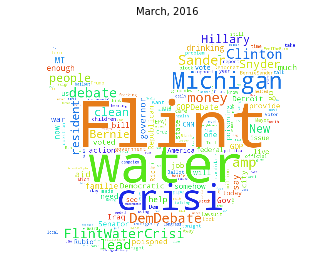

In [21]:
from wordcloud import WordCloud, STOPWORDS
from scipy.misc import imread
from PIL import Image
import numpy as np
import calendar
#mask = imread('twitter_mask.png', flatten=True)
mask = np.array(Image.open("twitter_mask.png"))
wc = WordCloud(mask=mask,background_color='white',stopwords=STOPWORDS,width=2200,height=1400).generate(words)
plt.figure().suptitle(calendar.month_name[month]+', 2016')
plt.axis('off')
plt.imshow(wc)
plt.savefig('figs/wc_'+calendar.month_name[month]+'.png', dpi=300, bbox_inches='tight')